# Setting up

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T
import torchvision.utils as U

import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

def image_transformation(img):
    return T.ToTensor()(img)

train_ds = FashionMNIST(root=".", train=True, download=True, transform=image_transformation)
test_ds = FashionMNIST(root=".", train=False, download=True, transform=image_transformation)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

100%|██████████| 26421880/26421880 [00:03<00:00, 8422016.99it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140273.67it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2592495.39it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24620612.31it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



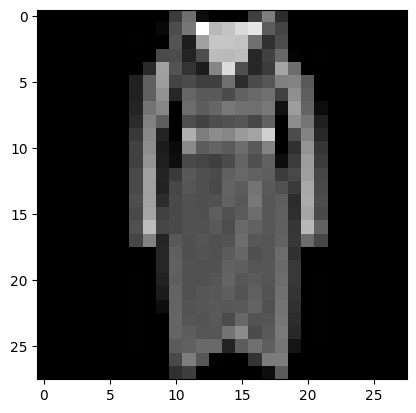

In [2]:
sample_imgs, sample_labels = next(iter(train_dataloader))
plt.imshow(sample_imgs[0].squeeze(dim=0), cmap="gray")

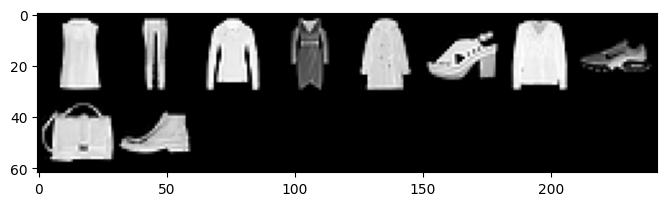

In [3]:
classes = torch.Tensor([])

for x in range(10):
    idx = (sample_labels == x).nonzero(as_tuple=True)[0][0]
    classes = torch.cat((classes, sample_imgs[idx]), 0)

grid = U.make_grid(classes.unsqueeze(dim=1), nrows=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
class FeaturePredictor(nn.Module):
    def __init__(self):
        super(FeaturePredictor, self).__init__()
        self.linear_stack = nn.Linear(676, 10)

    def forward(self, x):
        return self.linear_stack(x)

In [4]:
class BasicNetwork(nn.Module):
    def __init__(self):
        super(BasicNetwork, self).__init__()
        self.non_linearity = nn.Tanh
        self.kernel_size = (3, 3)
        self.padding_size = 1
        self.max_pooling_size = 2
        # self.conv_stack = nn.Sequential(
        #     nn.Conv2d(1, 3, self.kernel_size, padding=self.padding_size),
        #     self.non_linearity(),

        #     nn.Conv2d(3, 6, self.kernel_size, padding=self.padding_size),
        #     self.non_linearity(),

        #     nn.Conv2d(6, 12, self.kernel_size, padding=self.padding_size),
        #     self.non_linearity(),
        #     nn.MaxPool2d(self.max_pooling_size),


        #     nn.Conv2d(12, 24, self.kernel_size, padding=self.padding_size),
        #     self.non_linearity(),


        #     nn.Conv2d(24, 48, self.kernel_size, padding=self.padding_size),
        #     self.non_linearity(),
        #     nn.MaxPool2d(self.max_pooling_size),
        # )
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            self.non_linearity()
        )

        self.linear_stack = nn.Sequential(
            nn.Linear(6760, 3000),
            nn.ReLU(),
            nn.Linear(3000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        conv_output = self.conv_stack(x)
        # print("Convolution size : ", conv_output.shape, conv_output.flatten(start_dim=1).shape)
        linear_output = self.linear_stack(conv_output.flatten(start_dim=1))
        return linear_output


In [5]:
test_net = BasicNetwork().to(device)
test_net(sample_imgs.float().to(device)).shape
# test_net(sample_imgs)

torch.Size([64, 10])

# Training code

In [6]:
def train(model, dataloader, loss_func, optimizer_func, verbose=True):
    model.train()
    loss_arr = []

    for batch, (X, y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_func(pred, y)
        optimizer_func.zero_grad()
        loss.backward()
        optimizer_func.step()

        loss_arr.append(loss.item())

        if(verbose):
            if(batch%100 == 0):
                print(f'batch: {batch} loss: {loss.item()} [{batch*len(X)} / {len(dataloader.dataset)}]')
    return loss_arr

In [7]:
@torch.no_grad()
def test(model, dataloader):
    correct = 0
    total = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += sum(pred.argmax(dim=1) == y)
    return [correct, total]


# Hyperparameters Search

In [8]:

def test_learning_rates(Network, dataloader, learning_rates):
    losses = []
    for lr in learning_rates:
        loss_func = nn.CrossEntropyLoss()
        main_net = Network().to(device)
        optimizer_func = torch.optim.SGD(main_net.parameters(), lr=lr)

        loss_arr = train(main_net, dataloader, loss_func, optimizer_func, verbose=False)

        losses.append(loss_arr)
    return losses


In [9]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.9]
total_losses = test_learning_rates(BasicNetwork, train_dataloader, learning_rates)

rows,cols, idx = 2, 3, 0
subs = make_subplots(rows=rows, cols=cols, subplot_titles=learning_rates)

for row in range(rows):
    for col in range(cols):
        if(row == 1 and col == 2): break;
        subs.add_trace(go.Scatter(y=total_losses[idx]), row=row+1, col=col+1)
        idx+=1

subs.show()

In [10]:
def test_epochs(Network, dataloader, number_of_epochs, lr=0.9):
    epoch_list = []
    accuracy_list = []
    main_net = Network().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer_func = torch.optim.SGD(main_net.parameters(), lr=lr)

    for i in range(number_of_epochs):
        epoch_list.append(i)
        train(main_net, dataloader, loss_func, optimizer_func, verbose=False)
        correct, total = test(main_net, dataloader)
        accuracy_list.append(correct/total)
    return accuracy_list


In [11]:
test_output = test_epochs(BasicNetwork, train_dataloader, 20, 0.1)

In [12]:
temp = [x.cpu() for x in test_output]
px.line(temp)

In [13]:
def print_filters(image, layer, nrows=8, show_input_image=True):
    if show_input_image: plt.imshow(image.squeeze(dim=0), cmap="gray")
    image = image.to(device)
    output = layer(image)
    grid = U.make_grid(output.unsqueeze(dim=1), nrow=output.shape[0]//nrows+1)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.show()

#Training Loop

Epoch:  1


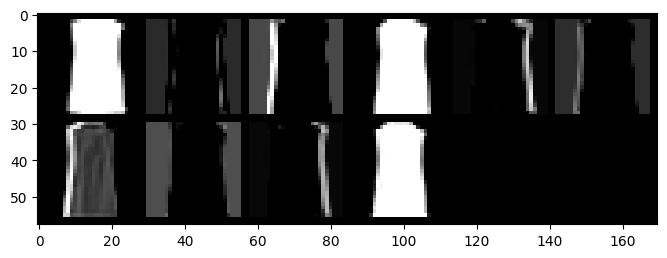

Epoch:  2


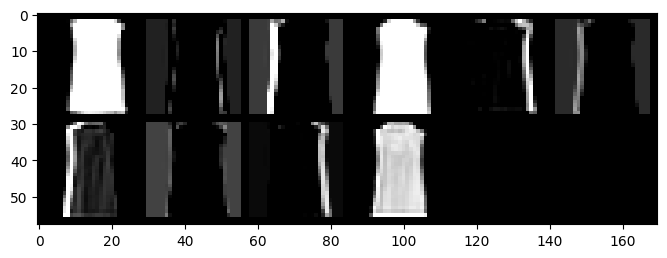

Epoch:  3


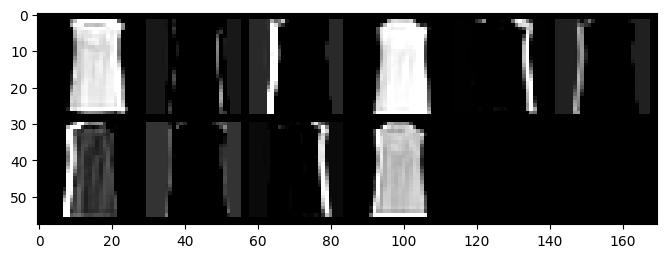

Epoch:  4


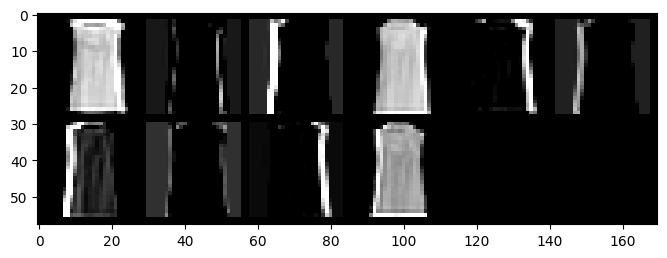

Epoch:  5


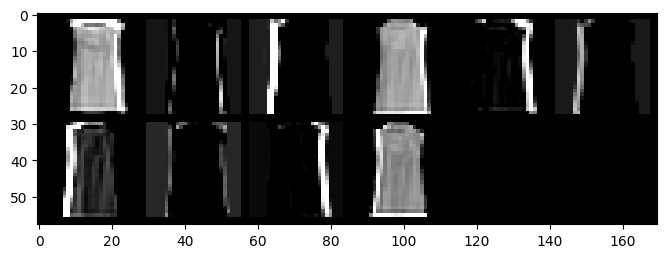

Epoch:  6


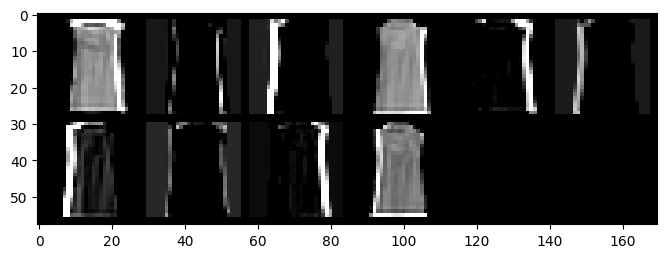

Epoch:  7


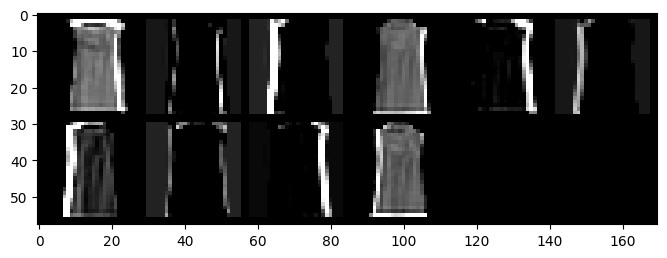

Epoch:  8


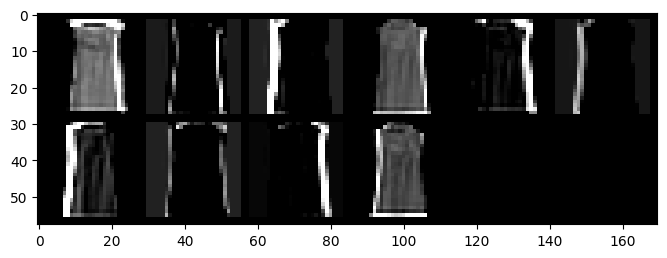

Epoch:  9


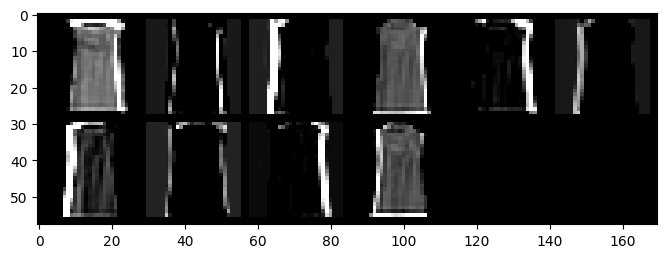

Epoch:  10


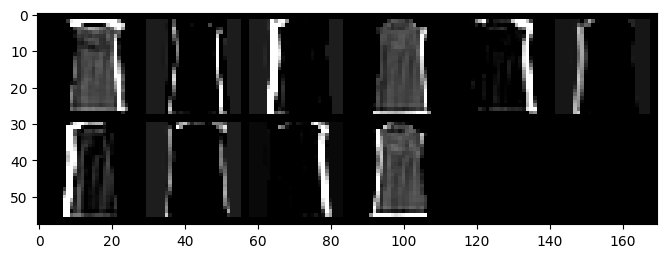

Epoch:  11


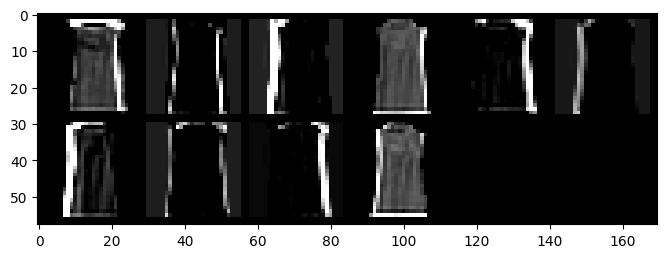

done


In [14]:
main_net = BasicNetwork().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer_func = torch.optim.SGD(main_net.parameters(), lr=0.1)

epochs = 11
for i in range(epochs):
    print("Epoch: ", i+1)
    train(main_net, train_dataloader, loss_func, optimizer_func, verbose=False)
    print_filters(classes[0].unsqueeze(dim=0), main_net.conv_stack[0], nrows=2, show_input_image=False)
print("done")

In [15]:
[correct, total] = test(main_net, test_dataloader)
print(f'Accuracy: {correct/total} [{correct}/{total}]')

Accuracy: 0.8967999815940857 [8968/10000]


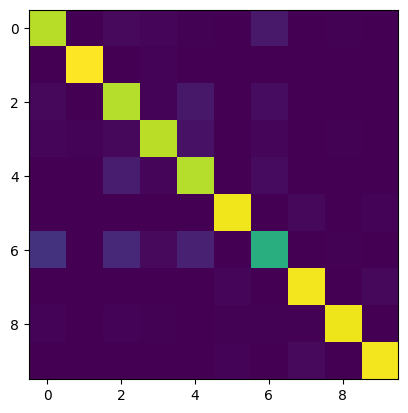

In [16]:
def build_confusion_matrix(main_net, dataloader, classes):
    total_preds = torch.Tensor([]).long().to(device)
    total_labels = torch.Tensor([]).long().to(device)

    for batch,(X, y) in enumerate(dataloader):
        X, y = X.to(device), y.long().to(device)
        pred = main_net(X).long()

        total_labels = torch.cat((total_labels, y), 0)
        total_preds = torch.cat((total_preds, pred.argmax(dim=1)), 0)

    matrix = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] for x in range(classes)]).long().to(device)

    for idx, label in enumerate(total_labels):
        matrix[label][total_preds[idx]] += 1

    return matrix.cpu()

conf_matrix = build_confusion_matrix(main_net, test_dataloader, classes = 10)
plt.imshow(conf_matrix)